In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import datetime

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
child_path = "Data/child_table.parquet"
consultation_path = "Data/consultation_table.parquet"

## Load, sample and filter the data

In [4]:
child_df = pd.read_parquet(child_path)

In [5]:
f"In total {len(child_df)} recorded children"

'In total 8924635 recorded children'

In [6]:
n_samples = 500_000
seed = 2
child_df = pd.read_parquet(child_path)
sampled_child_ids = child_df["child_id"].drop_duplicates().sample(n=n_samples, random_state=seed)
#sampled_child_ids = child_df['child_id'].drop_duplicates()

In [7]:
consultation_df = pd.read_parquet(consultation_path)

In [8]:
sampled_child_ids = set(sampled_child_ids)
latest_consultations = pd.DataFrame()

consultation_file = pq.ParquetFile(consultation_path)
for c in tqdm(consultation_file.iter_batches()):
    chunk = c.to_pandas()
    chunk_filtered = chunk[chunk["child_id"].isin(sampled_child_ids)]
    chunk_filtered = chunk_filtered.sort_values(by=["visit_date",'consult_count']).drop_duplicates("child_id", keep="last")

    latest_consultations = pd.concat([latest_consultations, chunk_filtered])
    latest_consultations = latest_consultations.sort_values(by=["visit_date",'consult_count']).drop_duplicates("child_id", keep="last")


357it [03:46,  1.57it/s]


In [9]:
latest_consultations = consultation_df[consultation_df['child_id'].isin(sampled_child_ids)].sort_values(by=["visit_date",'consult_count']).drop_duplicates("child_id", keep="last")

In [10]:
# save to parquet instead of csv, better compresion, and preserves datetime datatype
# alternatively for sampled:
latest_consultations_path = 'Data/latest_consultations_sampled.parquet'
# latest_consultations_path = 'Data/latest_consultations_all.parquet'
latest_consultations.to_parquet(latest_consultations_path, index=False)

In [11]:
sampled_child_table = child_df[child_df['child_id'].isin(sampled_child_ids)]
# save the sample child table in parquet format
sampled_child_table.to_parquet("Data/sampled_child_table.parquet")

## Child table

In [175]:
# change the path to work with either sampled or original child table
# child_path = "Data/sampled_child_table.parquet"
child_path = "Data/child_table.parquet"

child_table = pd.read_parquet(child_path)

### Correcting vaccine data

In [176]:
# understood as: if child is <= age (in month), it is okay if it hasn't received certain vaccine yet

vaccination_ages = {
    "penta_1": 2.8,
    "penta_2": 4,
    "penta_3": 9,
    "opv_0": 2,
    "opv_1": 2.8,
    "opv_2": 4,
    "opv_3": 9,
    "vpi": 9,
    "pneumo_1": 2.8,
    "pneumo_2": 4,
    "pneumo_3": 9,
    "bcg": 2,
    "rotavirus_1": 2.8,
    "rotavirus_2": 4,
    "rotavirus_3": 9,
    "measles_1": 15,
    "measles_2": np.inf,
    "yf": 15,  # yellow fever
    "men_a": np.inf  # meningitis A
}

In [ ]:
# First, we change yes/no values to bool
# interpret missing values as False

def map_to_bool(value):
    return True if value == "yes" or value is True else False


for vaccine in vaccination_ages.keys():
    child_table[vaccine] = child_table[vaccine].apply(map_to_bool)

# also change age to integer type
child_table["age_in_months"] = child_table["age_in_months"].astype(int)

We want to correct the data for each vaccine to reflect if the child has missed the vaccine, or if it just hasn't received becuse it is too young.

Each vaccine_x can only be received after certain age_x. For vaccine_x, we change vaccine_x to a boolean variable using the following rule:
- `True` always stays `True`
- `False` is changed to `True` if the child was not old enough to receive the vaccine and the last visit was within a year. This means that it is okay if the child hasn't received the vaccine if they are too young. But if they haven't come back within a year, they are now late for that vaccine, and considered as dropped out.

In [178]:
child_table['last_visit_date'].max()

Timestamp('2024-10-05 00:00:00')

In [179]:
# Set vaccines to True, if still under certain age and the last consultation was within last year

# set the reference date to the last date appearing in the table

reference_date = datetime.datetime.fromisoformat('2024-10-05')
one_year_ago = reference_date - datetime.timedelta(days=365)

for vaccine, max_age in vaccination_ages.items():
    child_table[vaccine] = child_table.apply(
        lambda row: True if (row["age_in_months"] <= max_age and row["last_visit_date"] >= one_year_ago) else row[vaccine], # 
        axis=1
    )

In [180]:
for col in vaccination_ages.keys():
    print(child_table[col].value_counts(dropna=False, normalize=True).mul(100).round(2))

penta_1
True     97.07
False     2.93
Name: proportion, dtype: float64
penta_2
True     95.81
False     4.19
Name: proportion, dtype: float64
penta_3
True     94.4
False     5.6
Name: proportion, dtype: float64
opv_0
True     97.32
False     2.68
Name: proportion, dtype: float64
opv_1
True     97.15
False     2.85
Name: proportion, dtype: float64
opv_2
True     95.86
False     4.14
Name: proportion, dtype: float64
opv_3
True     94.43
False     5.57
Name: proportion, dtype: float64
vpi
True     84.97
False    15.03
Name: proportion, dtype: float64
pneumo_1
True     97.0
False     3.0
Name: proportion, dtype: float64
pneumo_2
True     95.53
False     4.47
Name: proportion, dtype: float64
pneumo_3
True     93.31
False     6.69
Name: proportion, dtype: float64
bcg
True     97.46
False     2.54
Name: proportion, dtype: float64
rotavirus_1
True     96.87
False     3.13
Name: proportion, dtype: float64
rotavirus_2
True     95.61
False     4.39
Name: proportion, dtype: float64
rotavirus_3
Tru

Now that we have the corrected vaccine data, we correct `'all_vaccines'` so that it is `True` exactly when all (corrected) vaccine variables are `True`. This means that `'all_vaccines'` is `False` exactly when a child has missed some vaccine, meaning they "dropped out".

Similarly, we create a variable `'number_missed_vaccines'`, which reflect how many vaccine the child has missed.

We drop `'needs_vaccines'` as we don't need it.

In [181]:
# Correct all vaccines, drop need vaccines

vaccines = list(vaccination_ages.keys())

child_table["all_vaccines"] = child_table[vaccines].all(axis=1)

child_table = child_table.drop(columns=["needs_vaccines"])

vaccines_table = child_table[vaccines]

# total number of vaccines is 19
child_table['number_missed_vaccines'] = 19 - vaccines_table.sum(axis=1)

Text(0, 0.5, 'Frequency')

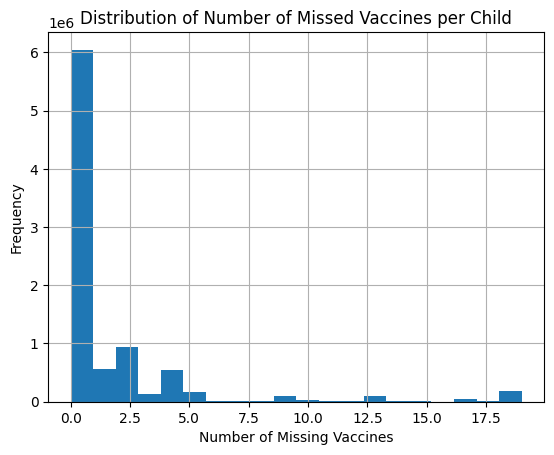

In [182]:
child_table['number_missed_vaccines'].hist(bins=20)
plt.title('Distribution of Number of Missed Vaccines per Child')
plt.xlabel('Number of Missing Vaccines')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency (in log scale)')

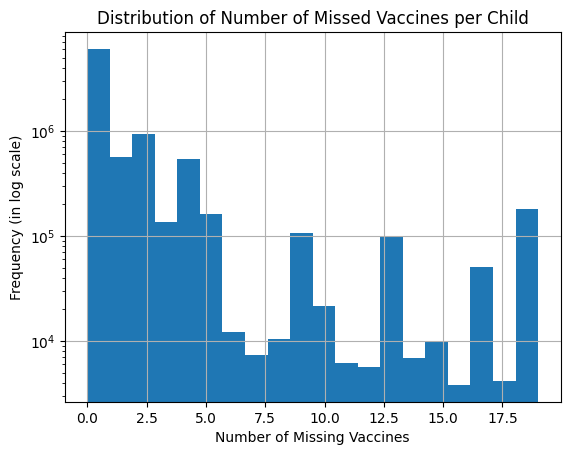

In [183]:
child_table['number_missed_vaccines'].hist(bins=20)
plt.yscale('log')
plt.title('Distribution of Number of Missed Vaccines per Child')
plt.xlabel('Number of Missing Vaccines')
plt.ylabel('Frequency (in log scale)')

In [184]:
child_table['all_vaccines'].value_counts(dropna=False,normalize=True).mul(100).round(2).astype(str)+'%'

all_vaccines
True     67.74%
False    32.26%
Name: proportion, dtype: object

Depending on the number of missed vaccines, we create potential risk categories:

0. $0$ missed vaccines
1. $1-2$ missed vaccines
2. $\geq 3$ missed vaccines

In [185]:
# Potential risk categories

risk_bins =  [-1,0,2,21]
risk_labels = [0,1,2]

child_table['missed_vaccines_category'] = pd.cut(child_table['number_missed_vaccines'],bins=risk_bins,labels=risk_labels)

child_table['missed_vaccines_category'] = child_table['missed_vaccines_category'].astype(int)

child_table['missed_vaccines_category'].value_counts(dropna=False,normalize=True).mul(100).round(2).astype(str) + '%'

missed_vaccines_category
0    67.74%
1    16.95%
2    15.32%
Name: proportion, dtype: object

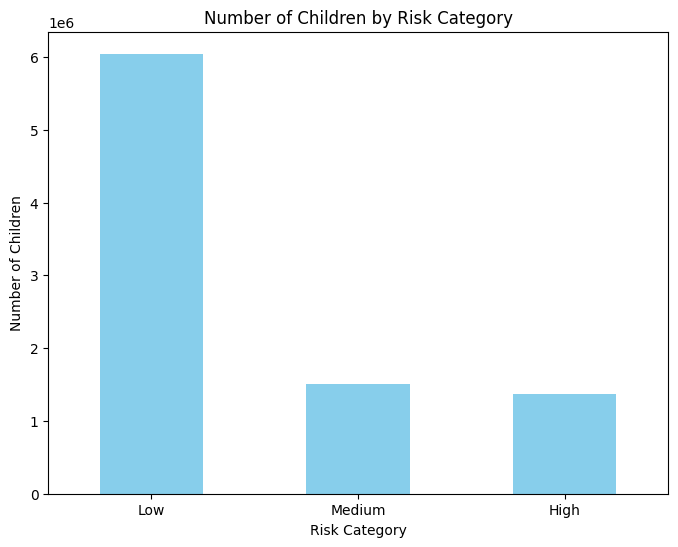

In [186]:
# Create a plot showing the number of children in each risk category

category_labels = {0: 'Low', 1: 'Medium', 2: 'High'}

risk_categories_labels = child_table['missed_vaccines_category'].map(category_labels)

# Count the number of children in each labeled category
category_counts = risk_categories_labels.value_counts().reindex(['Low', 'Medium', 'High'])

# Plot using pandas' native plotting function
category_counts.plot(kind='bar', color='skyblue', figsize=(8, 6))

plt.xlabel("Risk Category")
plt.ylabel("Number of Children")
plt.title("Number of Children by Risk Category")
plt.xticks(rotation=0) 
plt.show()


### Further data cleaning

We convert bool-type columns to boolean data type

In [187]:
bool_cols = ['mother_has_tel', 'acte_naissance_enfant', 'acte_naissance_mere','acte_naissance_pere','vitamin_a', 'vitamin_a_3_mois', 'vitamin_a_6_mois']

for col in bool_cols:
    child_table[col] = child_table[col].apply(map_to_bool)


In [196]:
# create a variable equaling the number of days between first and last consultation

child_table['first_last_visit_diff'] = (child_table['last_visit_date'] - child_table['first_visit_date']).dt.days.astype(int)

In [197]:
# convert other numerical variables to numeric types

child_table['weight'] = child_table['weight'].astype('float')
child_table['height'] = child_table['height'].astype('float')

# Calculate the mean, ignoring NaNs, then use this to impute missing values
muac_mean = pd.to_numeric(child_table['muac'], errors='coerce').mean()
child_table['muac'] = pd.to_numeric(child_table['muac'], errors='coerce').fillna(muac_mean)

child_table['consult_count'] = child_table['consult_count'].astype('int')
child_table['visit_frequency'] = child_table['first_last_visit_diff'] / child_table['consult_count']

In [198]:
# save this table
# change the path depending on if working with subsampled, or the whole table, or comment out if only want to save the final cleaned table
# child_path_corrected = 'Data/sampled_child_table_corrected.parquet'
child_path_corrected = 'Data/child_table_corrected.parquet'
child_table.to_parquet(child_path_corrected)

In [199]:
for col in  child_table.columns:
    if child_table[col].isnull().sum() > 0:
        print(col, str(child_table[col].isnull().mean()*100)+'%')

gender 2.2333238278092042%


In [200]:
# There are 2% of children with missing gender, we remove those
cleaned_child_table = child_table.dropna(subset=['gender'])

We concluded that the default values of district=='district' and region=='region' variables represent missing values in the original dataset. So we remove those. Note that exactly the same entries have district=='district' and region=='region' (in all the datasets)

In [201]:
cleaned_child_table = cleaned_child_table[cleaned_child_table['region_id']!='region']

We also calculate `'bmi'` for each child (as some values of `'weight'` and `'height'` seem impossible, and this is an easy way to filter out those, by removing outliers of `'bmi'`)

In [202]:
cleaned_child_table['bmi'] = cleaned_child_table['weight'] / (cleaned_child_table['height'] ** 2) * 10000

### Analyzing outliers

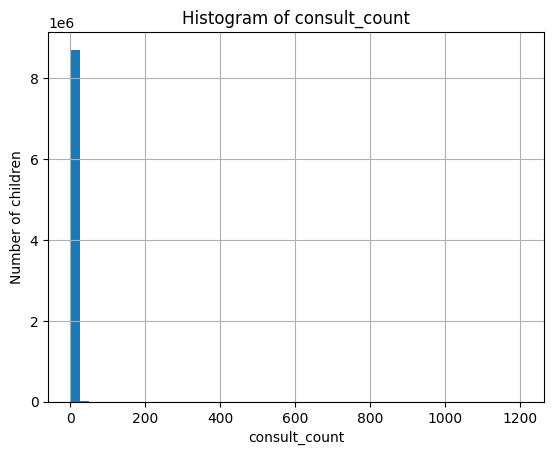

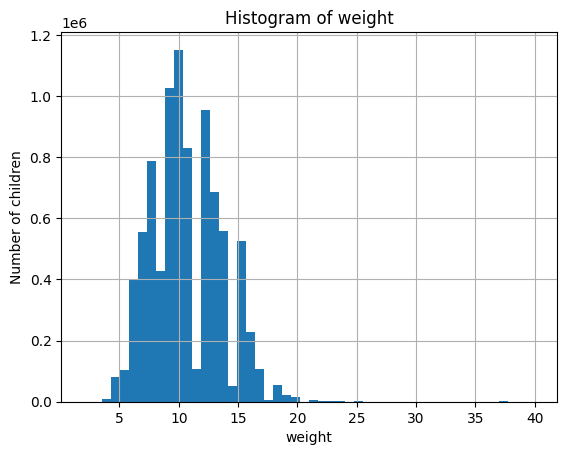

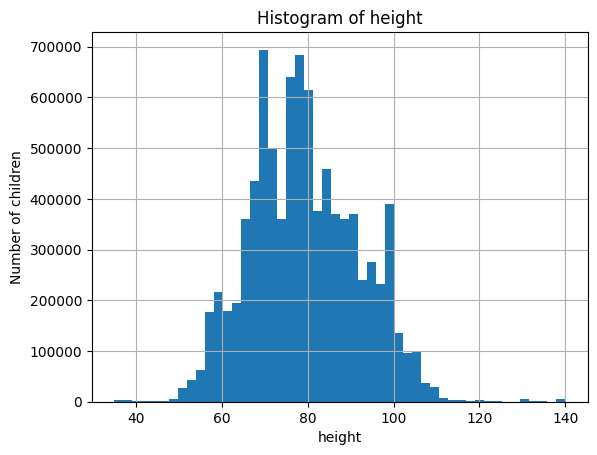

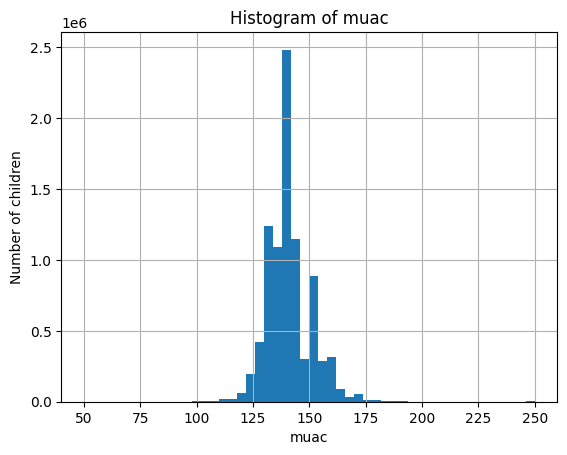

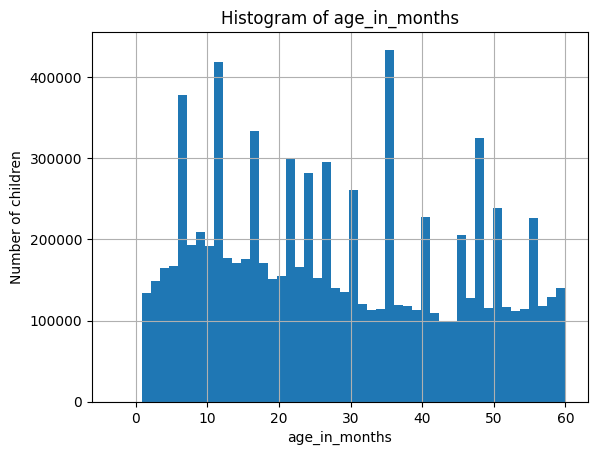

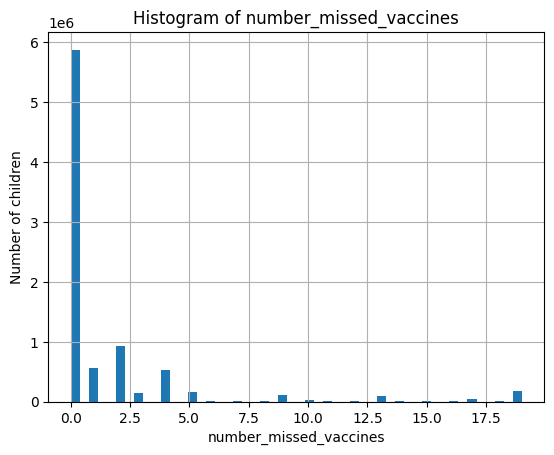

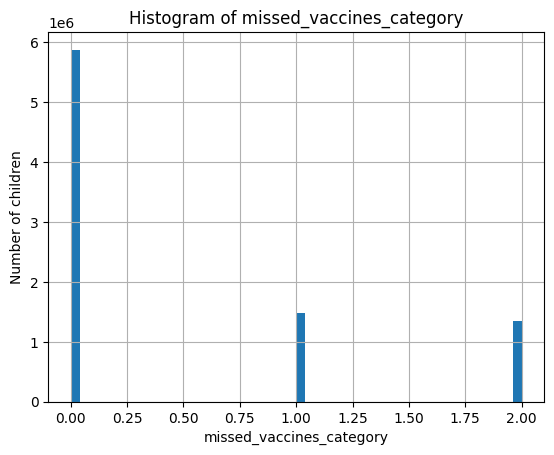

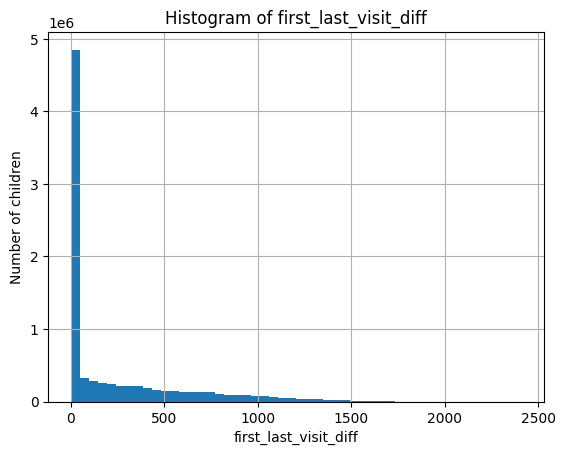

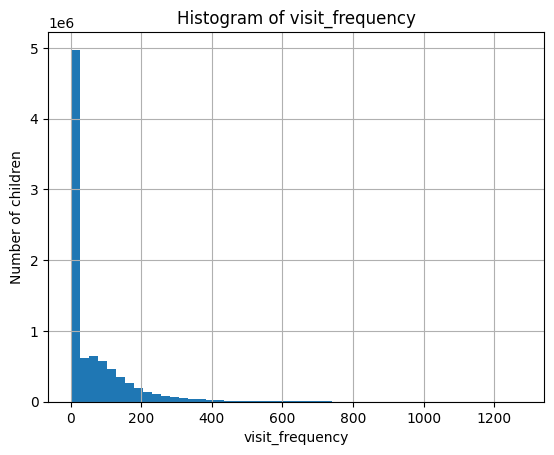

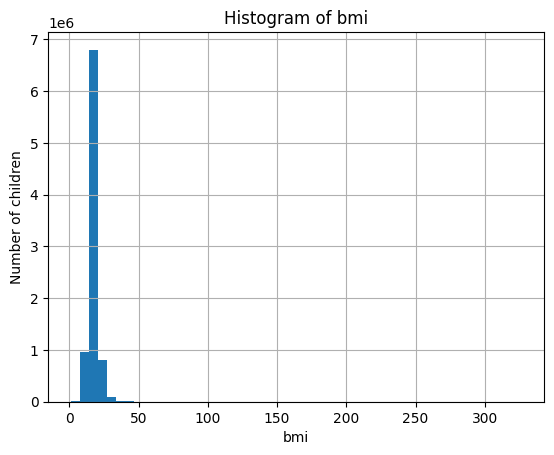

In [203]:
# Look at all the numerical columns
numerical = cleaned_child_table.select_dtypes(include=np.number)

numerical_columns = numerical.columns

for col in numerical_columns:
    numerical[col].hist(bins=50)
    plt.xlabel(col)
    plt.ylabel("Number of children")
    plt.title("Histogram of "+col)
    plt.show()

In [204]:
for col in numerical_columns:
    display(cleaned_child_table[col].describe())

count    8.709198e+06
mean     2.725973e+00
std      2.945980e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      1.204000e+03
Name: consult_count, dtype: float64

count    8.709198e+06
mean     1.066537e+01
std      2.981070e+00
min      2.000000e+00
25%      8.500000e+00
50%      1.000000e+01
75%      1.300000e+01
max      4.000000e+01
Name: weight, dtype: float64

count    8.709198e+06
mean     7.929538e+01
std      1.264003e+01
min      3.500000e+01
25%      7.000000e+01
50%      7.800000e+01
75%      8.800000e+01
max      1.400000e+02
Name: height, dtype: float64

count    8.709198e+06
mean     1.406491e+02
std      1.013738e+01
min      5.000000e+01
25%      1.350000e+02
50%      1.400000e+02
75%      1.450000e+02
max      2.500000e+02
Name: muac, dtype: float64

count    8.709198e+06
mean     2.822624e+01
std      1.661499e+01
min     -3.000000e+00
25%      1.300000e+01
50%      2.600000e+01
75%      4.200000e+01
max      6.000000e+01
Name: age_in_months, dtype: float64

count    8.709198e+06
mean     1.505998e+00
std      3.599992e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      1.900000e+01
Name: number_missed_vaccines, dtype: float64

count    8.709198e+06
mean     4.793710e-01
std      7.473082e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.000000e+00
Name: missed_vaccines_category, dtype: float64

count    8.709198e+06
mean     2.305805e+02
std      3.538908e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.700000e+02
max      2.410000e+03
Name: first_last_visit_diff, dtype: float64

count    8.709198e+06
mean     5.731608e+01
std      9.200229e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.920000e+01
max      1.278000e+03
Name: visit_frequency, dtype: float64

count    8.709198e+06
mean     1.705236e+01
std      4.137538e+00
min      1.020408e+00
25%      1.487290e+01
50%      1.632653e+01
75%      1.828989e+01
max      3.265306e+02
Name: bmi, dtype: float64

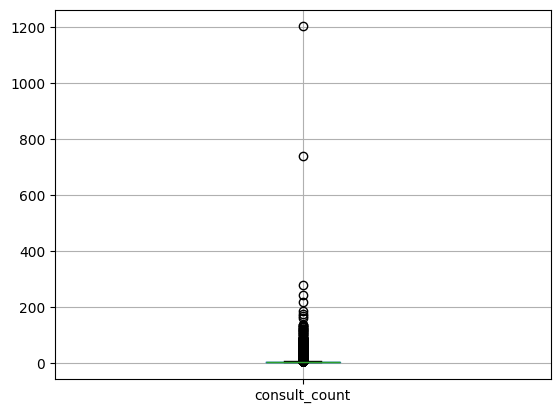

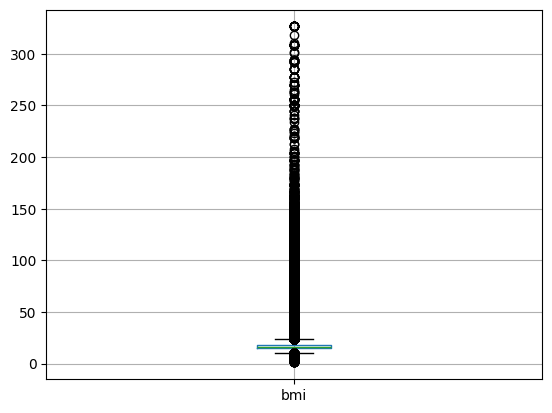

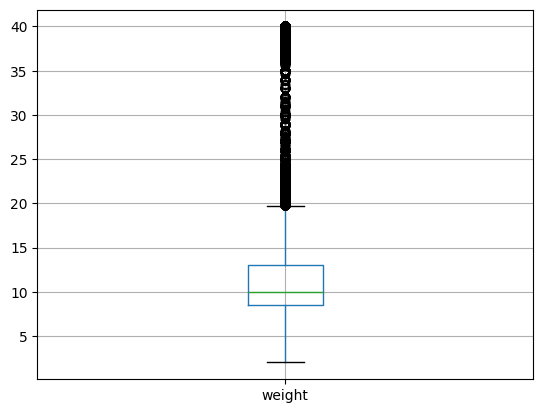

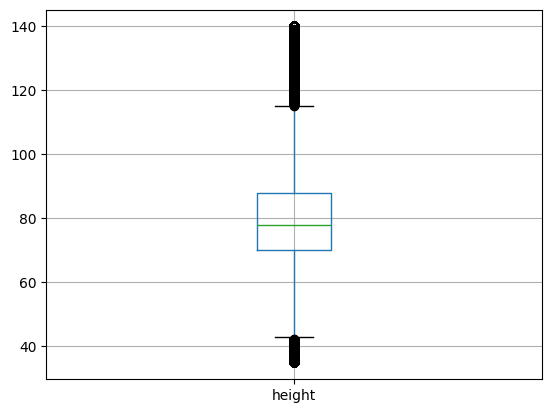

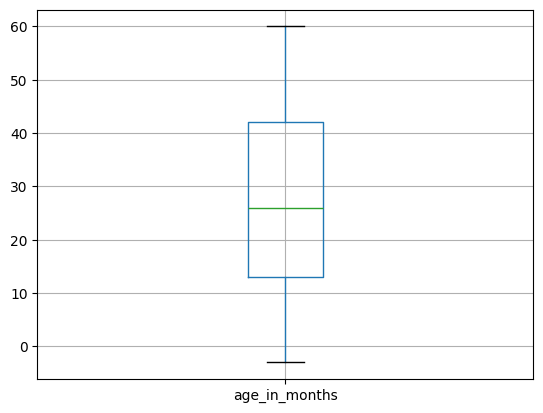

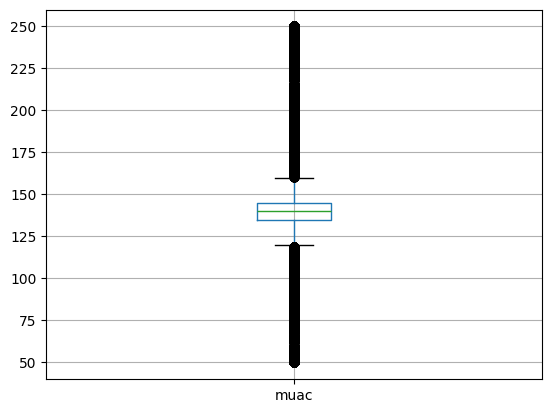

In [205]:
cleaned_child_table.boxplot(column=['consult_count'])
plt.show()
cleaned_child_table.boxplot(column=['bmi'])
plt.show()
cleaned_child_table.boxplot(column=['weight'])
plt.show()
cleaned_child_table.boxplot(column=['height'])
plt.show()
cleaned_child_table.boxplot(column=['age_in_months'])
plt.show()
cleaned_child_table.boxplot(column=['muac'])
plt.show()

We want to remove the outliers of consult_count and bmi. As both of those have skewed distributions, we use the IQR method.

We use threshold = 3, so we are not very harsh with removing outliers

In [206]:
def remove_outliers_iqr(df, columns, threshold=3):
    outliers_counts = {}
    for col in columns:
        Q1 = np.quantile(df[col], 0.25)
        Q3 = np.quantile(df[col], 0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        outliers_counts[col] = outliers.sum()  # Count the outliers
        # Remove outliers
        df = df[~outliers]
        print(f"Lower bound for {col}: {lower_bound}, Upper bound for {col}: {upper_bound}")
    return df, outliers_counts

cleaned_child_table, outliers_counts = remove_outliers_iqr(cleaned_child_table,['consult_count', 'bmi'])

# Print the results
print("Outliers counts per column:")
for column, count in outliers_counts.items():
    print(f"{column}: {count} outliers removed")


Lower bound for consult_count: -5.0, Upper bound for consult_count: 9.0
Lower bound for bmi: 4.621932591004974, Upper bound for bmi: 28.540866514679507
Outliers counts per column:
consult_count: 331464 outliers removed
bmi: 95442 outliers removed


`'distance'` is currently just a string. We convert it to a numeric variable, by encoding first two categories as mean distance, and estimating `'above ten'` as 20

In [207]:
# Convert distance to numeric, by encoding first two as mean distance, and estimating above ten as 20
cleaned_child_table['distance_numeric'] = cleaned_child_table['distance'].map({'less_four':2, 'four_to_ten': 7, 'above_ten': 20})
cleaned_child_table.drop(columns=['distance'],inplace=True)

In [208]:
cleaned_child_table = pd.get_dummies(cleaned_child_table, columns=['gender'])

In [210]:
# save this table
# change the path depending on if working with subsampled, or the whole table, or comment out if only want to save the final cleaned table
# child_path_cleaned = 'Data/sampled_child_table_cleaned.parquet'
child_path_cleaned = 'Data/child_table_cleaned.parquet'
cleaned_child_table.to_parquet(child_path_cleaned)

In [211]:
cleaned_child_table['phc_id'].nunique()

1988

We'll now merge this cleaned table with consultation data. First we take into account only the last consultation for each, then we consider all consultations. We clean both tables so that they are ready for training, so we can test models with both approaches.

## Merging with last consultation table

In [220]:
# merge only child_id-s that are in the cleaned table - we don't want outliers

merged_last_consultation_table = latest_consultations[latest_consultations['child_id'].isin(cleaned_child_table['child_id'])]

In [223]:
merged_last_consultation_table.columns

Index(['consultation_id', 'child_id', 'visit_date', 'consult_count',
       'distance', 'age_in_months', 'all_vaccines', 'needs_vaccines', 'phc_id',
       'district_id', 'region_id', 'penta_1', 'penta_2', 'penta_3', 'opv_0',
       'opv_1', 'opv_2', 'opv_3', 'vpi', 'pneumo_1', 'pneumo_2', 'pneumo_3',
       'bcg', 'rotavirus_1', 'rotavirus_2', 'rotavirus_3', 'measles_1',
       'measles_2', 'yf', 'men_a', 'has_diarrhea', 'has_dehydration',
       'has_dysentery', 'has_anemia', 'has_pneumonia', 'has_malaria',
       'has_measles', 'has_malnutrition', 'has_danger_signs', 'has_fever',
       'has_hiv', 'has_suspicion_asthma', 'has_suspicion_tuberculosis',
       'has_suspicion_asthma_tuberculosis',
       'has_at_least_one_severe_condition',
       'has_at_least_one_moderate_condition'],
      dtype='object')

For the columns that are repeated in both child and consultation table, we keep the data from the child table. We also don't need `'needs_vaccines'` nor `'consultation_id'`.

So the columns that we merge is the data about diseases from consultations.

In [224]:
columns_to_merge = [
    'child_id', 'has_diarrhea', 'has_dehydration', 'has_dysentery', 'has_anemia', 'has_pneumonia', 'has_malaria', 
    'has_measles', 'has_malnutrition', 'has_danger_signs', 'has_fever', 'has_hiv', 'has_suspicion_asthma', 
    'has_suspicion_tuberculosis', 'has_suspicion_asthma_tuberculosis', 'has_at_least_one_severe_condition', 'has_at_least_one_moderate_condition'
]

merged_last_consultation_table = pd.merge(cleaned_child_table, merged_last_consultation_table[columns_to_merge], on='child_id', how='left')

Drop columns that are not useful for training:
- `'first_visit_date'`, `'last_visit_date'`
- specific vaccine data
- `'child_id'`, `'consultation_id'`
- `'phc_id'` as there are 1986 different categories, and including it didn't improve the model

For `'district_id'` and `'region_id'` we get dummy variables

In [225]:
merged_last_consultation_table.drop(inplace=True, columns=['first_visit_date', 'last_visit_date'])
merged_last_consultation_table.drop(inplace=True, columns=vaccines)

In [226]:
merged_last_consultation_table.drop(inplace=True, columns=['child_id', 'phc_id'])
merged_last_consultation_table = pd.get_dummies(merged_last_consultation_table, columns=['district_id','region_id'])

In [227]:
# change disease columns into bool

bool_columns = ['has_anemia', 'has_pneumonia', 'has_malaria', 'has_measles',
       'has_malnutrition', 'has_danger_signs', 'has_fever', 'has_hiv',
       'has_suspicion_asthma', 'has_suspicion_tuberculosis',
       'has_suspicion_asthma_tuberculosis',
       'has_at_least_one_severe_condition',
       'has_at_least_one_moderate_condition','has_dehydration']

for col in bool_columns:
    merged_last_consultation_table[col] = merged_last_consultation_table[col].apply(map_to_bool)

In [228]:
# This is now in a cleaned form ready for training, export it
# change the path depending on if working with subsampled, or the whole table, or comment out if only want to save the final cleaned table

# merged_last_consultation_table_for_training_path = 'Data/sampled_merged_last_consultation_for_training.parquet'
merged_last_consultation_table_for_training_path = 'Data/merged_last_consultation_for_training.parquet'

merged_last_consultation_table.to_parquet(merged_last_consultation_table_for_training_path)

## Merging with all consultations

In [263]:
# only look at consultations for those children that are in the clean_child_table (no outliers)
consultation_table = consultation_df[consultation_df['child_id'].isin(cleaned_child_table['child_id'])]

As for the previous case, we keep only the disease columns (other data is already in the child table).

Also note that for training our target is the final, true value of `'all_vaccines'` (did the child drop out), and not the intermediate values.

In [264]:
bool_columns = ['has_anemia', 'has_pneumonia', 'has_malaria', 'has_measles',
       'has_malnutrition', 'has_danger_signs', 'has_fever', 'has_hiv',
       'has_suspicion_asthma', 'has_suspicion_tuberculosis',
       'has_suspicion_asthma_tuberculosis',
       'has_at_least_one_severe_condition',
       'has_at_least_one_moderate_condition','has_dehydration']

for col in bool_columns:
    consultation_table[col] = consultation_table[col].apply(map_to_bool)

consultation_table.drop(columns=['needs_vaccines','all_vaccines','consult_count','consultation_id','visit_date'],inplace=True)
consultation_table.drop(columns=vaccines, inplace=True)

consultation_table['age_in_months'] = consultation_table['age_in_months'].astype(int)

# Convert distance to numeric, by encoding first two as mean distance, and estimating above ten as 20
consultation_table['distance_numeric'] = consultation_table['distance'].map({'less_four':2, 'four_to_ten': 7, 'above_ten': 20})
consultation_table.drop(columns=['distance'],inplace=True)

/var/folders/73/27rcxr7s4h38qt__hq029g7h0000gq/T/ipykernel_13234/916906257.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultation_table[col] = consultation_table[col].apply(map_to_bool)
/var/folders/73/27rcxr7s4h38qt__hq029g7h0000gq/T/ipykernel_13234/916906257.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultation_table.drop(columns=['needs_vaccines','all_vaccines','consult_count','consultation_id','visit_date'],inplace=True)
/var/folders/73/27rcxr7s4h38qt__hq029g7h0000gq/T/ipykernel_13234/916906257.py:12: SettingWithCopyWarning: 
A value is 

In [265]:
columns_to_merge_from_child = ['child_id', 'consult_count',
       'mother_has_tel', 'acte_naissance_enfant', 'acte_naissance_mere',
       'acte_naissance_pere', 'weight', 'height', 'muac',
       'vitamin_a', 'vitamin_a_3_mois', 'vitamin_a_6_mois','all_vaccines',
       'number_missed_vaccines', 'missed_vaccines_category',
       'first_last_visit_diff', 'bmi', 'visit_frequency','gender_female', 'gender_male']

cleaned_consultation_table = pd.merge(
    consultation_table,
    cleaned_child_table[columns_to_merge_from_child],
    on='child_id',
    how='left')

In [266]:
cleaned_consultation_table.drop(inplace=True, columns=['phc_id'])

cleaned_consultation_table = pd.get_dummies(cleaned_consultation_table, columns=['district_id', 'region_id'])

In [267]:
for col in cleaned_consultation_table:
    if cleaned_consultation_table[col].isnull().sum() > 0:
        print(col, cleaned_consultation_table[col].isnull().mean()*100)

distance_numeric 0.006731315014508645


There are (very) few entries with missing value for distance, so we just drop these.

In [268]:
cleaned_consultation_table.dropna(subset=['distance_numeric'],inplace=True)

In [269]:
sampled_cleaned_consultation_table = cleaned_consultation_table[cleaned_consultation_table['child_id'].isin(sampled_child_ids)]

In [271]:
cleaned_consultation_table.drop(columns=['child_id'], inplace=True)
sampled_cleaned_consultation_table.drop(columns=['child_id'], inplace=True)

/var/folders/73/27rcxr7s4h38qt__hq029g7h0000gq/T/ipykernel_13234/3020977700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_cleaned_consultation_table.drop(columns=['child_id'], inplace=True)


In [272]:
# This is now in a cleaned form ready for training, export it
# change the path depending on if working with subsampled, or the whole table, or comment out if only want to save the final cleaned table

#cleaned_consultation_table_path = "Data/sampled_consultation_table_for_training.parquet"
cleaned_consultation_table_path = "Data/consultation_table_for_training.parquet"

cleaned_consultation_table.to_parquet(cleaned_consultation_table_path)

In [273]:
sampled_cleaned_consultation_table_path = "Data/sampled_consultation_table_for_training.parquet"

sampled_cleaned_consultation_table.to_parquet(sampled_cleaned_consultation_table_path)